In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import expit, logit
import time
import snap
import pandas as pd
import prox_tv as ptv

# Cas simple

In [2]:
#power2, gaussian noise, r = 3
#Pas cst
d = 1000
z0 = 5.0*np.random.randn(d)
R = np.linalg.norm(z0)
sigma = 4.0
r = 3.0
size = 20
many_random_sample = 100

def F(z):
    return 1/float(2)*np.linalg.norm(z)**2
F(z0)

12641.821151193944

In [ ]:
Nesterov_mean = np.asarray([0]*(size))
Polyak_mean = np.asarray([0]*(size))
            
for many in range(many_random_sample):
    Nesterov = [F(z0)]
    Polyak = [F(z0)]
    
    for N in xrange(1, size):

        gamma_nest = (r - 1) * np.sqrt((3*R)/float(1.1*sigma*sigma)) * (N + r - 2)**(-3/float(2))
        gamma_pol = np.sqrt((R)/float(2 * (N) * sigma*sigma))
        
        z = np.copy(z0)
        x = np.copy(z)

        #Nesterov
        for n in range(N):
            grad = z + sigma * np.random.randn(d)
            descent = z - gamma_nest * grad
            x0 = np.copy(x)
            #if np.abs(descent) > (1/float(n+1)):
            #    x = descent - np.sign(descent) * (1/float(n+1))
            #else:
            #    x = 0
            x = np.copy(descent)
            z = x + (n)/float(n + 3)*(x - x0)
        
        Nesterov += [F(z)]
    
        z = np.copy(z0)
        zbar = 0
        #Polyak
        for n in range(N):
            #print(n)
            grad = z + sigma * np.random.randn()
            descent = z - gamma_pol * grad
            #print (z)
            #if np.abs(descent) > (gamma):
            #    z = descent - np.sign(descent) * (gamma)
            #else:
            #    z = 0
            z = np.copy(descent)
            zbar = zbar - (1)/float(n + 1)*(zbar - z)
        Polyak += [F(zbar)]
        
        
    Nesterov_mean = Nesterov_mean - (1)/float(many + 1)*(Nesterov_mean - np.asarray(Nesterov))
    Polyak_mean = Polyak_mean - (1)/float(many + 1)*(Polyak_mean - np.asarray(Polyak))    


%matplotlib inline

nesterov = plt.plot(Nesterov_mean,marker = 'o',label = 'Stochastic FISTA')
polyak = plt.plot(Polyak_mean,marker = '.',label = 'Polyak-Ruppert averaging')
 
plt.xlabel('n')
plt.ylabel('1/2*|x|^2')
plt.title('The Objective as a function of n')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
#plt.savefig('Nesterov-power2-20.png')
plt.show()
#On sait que dans ce cas Polyak va même a la vitesse 1/n cf Bach Moulines
#Simu pour le SGD sans averaging? Quel est le pas optimal?

# Regression logistique 

In [2]:
#reglog, real data, r = 3
#Pas cst

def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

def Seuillage_Doux(x, seuil = 1.0):
    z = np.copy(x)
    for i in range(len(x)):
        if np.abs(x[i]) > seuil:
            z[i] = x[i] - np.sign(x[i])*seuil
        else:
            z[i] = 0
    return z 

def H(z, y, X):
    b = 1 / float(N) * sum([np.log(1 + np.exp(-y[j]*np.dot(z,X[j]))) for j in range(N)]) #ajouter intercept
    return b

def G(z):
    a = np.linalg.norm(z,1)
    return a

def F(z, y, X, lambd = 1.0):
    a = lambd * np.linalg.norm(z,1)
    b = 1 / float(N) * sum([np.log(1 + np.exp(-y[j]*np.dot(z,X[j]))) for j in range(N)]) #ajouter intercept
    return a + b

X, y = load_diabetic_retinopathy('diabeticRetinopathy.csv', minidata=False)
N = X.shape[0]
d = X.shape[1]
X = np.concatenate((X, np.ones((N,1))), axis=1)
N = X.shape[0]
d = X.shape[1]
print (N,d)

z0 = 5.0 * np.random.randn(d)
print F(z0, y, X, lambd = 1.0)

r = 3.5
sizes = 200
many_random_sample = 10
subsample = 100
lambd = 0.1
pas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 7.5, 10.0]

(1151, 20)
54.164785022


In [3]:
tip = time.time()
Nesterov = {}
Polyak = {}

for gamma in pas: #pas
    Nesterov[gamma] = np.zeros((many_random_sample, sizes))
    Polyak[gamma] = np.zeros((many_random_sample, sizes))
    for k in range(many_random_sample):
        z = np.copy(z0)
        x = np.copy(z0)
        u = np.copy(z0)
        ubar = np.copy(z0)
        for n in range(sizes):
            Polyak[gamma][k,n] = F(ubar, y, X, lambd)
            Nesterov[gamma][k,n] = F(x, y, X, lambd)
    
            Liste = np.random.randint(N, size = subsample)
            grad = sum([-y[j] * expit(-y[j]*np.dot(z,X[j])) * X[j] for j in Liste])
            #Polyak
            u = Seuillage_Doux(u - gamma/np.float(subsample) * grad, gamma*lambd)
            ubar = ubar - 1/float(n+1) * (ubar - u)
            #Nesterov
            x0 = np.copy(x)
            x = Seuillage_Doux(z - gamma/np.float(subsample) * grad, gamma*lambd)
            z = x + (n)/float(n + 3)*(x - x0)
            
    Nesterov[(gamma,'mean')] = np.mean(Nesterov[gamma], axis=0)
    Polyak[(gamma,'mean')] = np.mean(Polyak[gamma], axis=0)
    nest = pd.DataFrame(Nesterov[gamma])
    pol = pd.DataFrame(Polyak[gamma])
    Nesterov[(gamma,'quartileup')] = nest.quantile(q=0.90, axis = 0)
    Polyak[(gamma,'quartileup')] = pol.quantile(q=0.90, axis = 0)
    Nesterov[(gamma,'quartiledown')] = nest.quantile(q=0.10, axis = 0)
    Polyak[(gamma,'quartiledown')] = pol.quantile(q=0.10, axis = 0)
        
        
top = time.time()
print (top - tip)

280.402677059


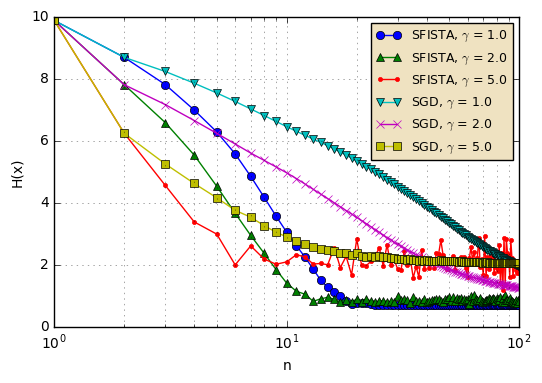

In [4]:
#from matplotlib.font_manager import FontProperties

%matplotlib inline
#Polyak 1, 2, 5, 10
#Nesterov 0.2, 0.5, 1.0, 2.0
plt.plot(list(xrange(1,101)), Nesterov[(1.0,'mean')][0:100],marker = 'o',label = r'SFISTA, $\gamma $ = '+str(1.0))
plt.plot(list(xrange(1,101)), Nesterov[(2.0,'mean')][0:100],marker = '^',label = r'SFISTA, $\gamma $ = '+str(2.0))
plt.plot(list(xrange(1,101)), Nesterov[(5.0,'mean')][0:100],marker = '.',label = r'SFISTA, $\gamma $ = '+str(5.0))
#plt.plot(list(xrange(1,101)), Nesterov[(7.5,'mean')][0:100],marker = '+',label = r'Stochastic FISTA, $\gamma $ = '+str(7.5))
plt.plot(list(xrange(1,101)), Polyak[(1.0,'mean')][0:100],marker = 'v',label = r'SGD, $\gamma $ = '+str(1.0))
plt.plot(list(xrange(1,101)), Polyak[(2.0,'mean')][0:100],marker = 'x',label = r'SGD, $\gamma $ = '+str(2.0))
plt.plot(list(xrange(1,101)), Polyak[(5.0,'mean')][0:100],marker = 's',label = r'SGD, $\gamma $ = '+str(5.0))
#plt.plot(list(xrange(1,101)), Polyak[(7.5,'mean')][0:100],marker = 'd',label = r'SGD, $\gamma $ = '+str(7.5))


plt.xlabel('n')
plt.ylabel('H(x)')
#plt.title('The Objective function values as a function of n')
legend = plt.legend(loc='upper right', prop={'size':9})
legend.get_frame().set_facecolor('#efe2c1')
plt.xscale('log')
plt.grid(which = 'both', alpha = 0.5)
plt.savefig('Fista-gamma-mean-1.png')
plt.show()

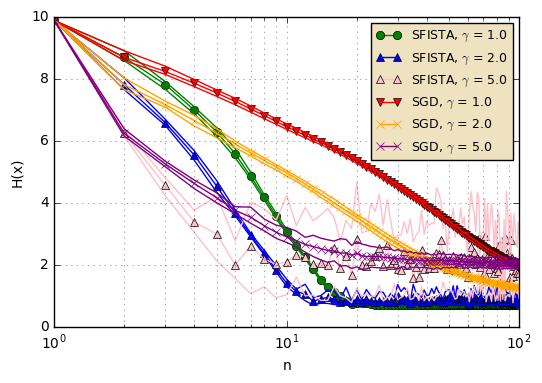

In [7]:
#from matplotlib.font_manager import FontProperties

%matplotlib inline
#Polyak 1, 2, 5, 10
#Nesterov 0.2, 0.5, 1.0, 2.0

plt.plot(list(xrange(1,101)), Nesterov[(1.0,'mean')][0:100],marker = 'o',label = r'SFISTA, $\gamma $ = '+str(1.0), color = 'green')
plt.plot(list(xrange(1,101)), Nesterov[(1.0,'quartileup')][0:100], color = 'green')
plt.plot(list(xrange(1,101)), Nesterov[(1.0,'quartiledown')][0:100], color = 'green')

plt.plot(list(xrange(1,101)), Nesterov[(2.0,'mean')][0:100],marker = '^',label = r'SFISTA, $\gamma $ = '+str(2.0), color = 'blue')
plt.plot(list(xrange(1,101)), Nesterov[(2.0,'quartileup')][0:100], color = 'blue')
plt.plot(list(xrange(1,101)), Nesterov[(2.0,'quartiledown')][0:100], color = 'blue')

plt.plot(list(xrange(1,101)), Nesterov[(5.0,'mean')][0:100],marker = '^',label = r'SFISTA, $\gamma $ = '+str(5.0), color = 'pink')
plt.plot(list(xrange(1,101)), Nesterov[(5.0,'quartileup')][0:100], color = 'pink')
plt.plot(list(xrange(1,101)), Nesterov[(5.0,'quartiledown')][0:100], color = 'pink')

plt.plot(list(xrange(1,101)), Polyak[(1.0,'mean')][0:100],marker = 'v',label = r'SGD, $\gamma $ = '+str(1.0), color = 'red')
plt.plot(list(xrange(1,101)), Polyak[(1.0,'quartileup')][0:100], color = 'red')
plt.plot(list(xrange(1,101)), Polyak[(1.0,'quartiledown')][0:100], color = 'red')

plt.plot(list(xrange(1,101)), Polyak[(2.0,'mean')][0:100],marker = 'x',label = r'SGD, $\gamma $ = '+str(2.0), color = 'orange')
plt.plot(list(xrange(1,101)), Polyak[(2.0,'quartileup')][0:100], color = 'orange')
plt.plot(list(xrange(1,101)), Polyak[(2.0,'quartiledown')][0:100], color = 'orange')

plt.plot(list(xrange(1,101)), Polyak[(5.0,'mean')][0:100],marker = 'x',label = r'SGD, $\gamma $ = '+str(5.0), color = 'purple')
plt.plot(list(xrange(1,101)), Polyak[(5.0,'quartileup')][0:100], color = 'purple')
plt.plot(list(xrange(1,101)), Polyak[(5.0,'quartiledown')][0:100], color = 'purple')


plt.xlabel('n')
plt.ylabel('H(x)')
#plt.title('The Objective function values as a function of n')
legend = plt.legend(loc='upper right', prop={'size':9})
legend.get_frame().set_facecolor('#efe2c1')
plt.xscale('log')
plt.grid(which = 'both', alpha = 0.5)
plt.savefig('Fista-gamma-var-2.png')
plt.show()

91.5423939228


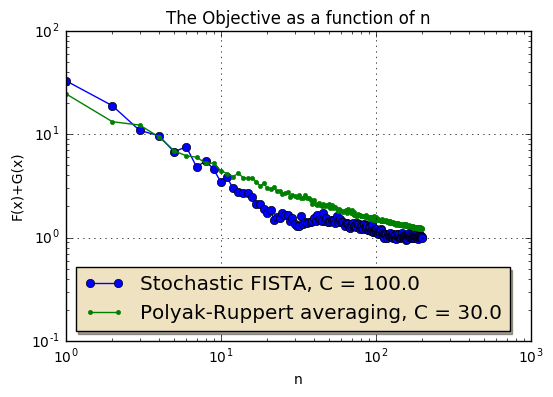

In [6]:
Nesterov_mean = np.asarray([0]*(size))
Polyak_mean = np.asarray([0]*(size))
      
tip = time.time()
for many in range(many_random_sample):
    Nesterov = [F(z0, y, X, lambd)]
    Polyak = [F(z0, y, X, lambd)]
    
    for Nb in xrange(1, size):
        #print (Nb)
        gamma_nest = C_nest * ((Nb + r - 2)**(-3/float(2))) #Verifier que ces formules sont encore vraies avec un backward
        gamma_pol = C_pol / np.sqrt(Nb) #En subsampling, sigma est vraiement inconnu?
        
        z = np.copy(z0)
        x = np.copy(z)
        #Nesterov
        for n in range(Nb):
            Liste = np.random.randint(N, size = subsample)
            grad = sum([-y[j] * expit(-y[j]*np.dot(z,X[j])) * X[j] for j in Liste])
            descent = z - gamma_nest/np.float(subsample) * grad
            x0 = np.copy(x)
            x = Seuillage_Doux(descent, gamma_nest*lambd)
            z = x + (n)/float(n + 3)*(x - x0)
        Nesterov += [F(z, y, X, lambd)]
        #print (np.linalg.norm(z,0))
        z = np.copy(z0)
        zbar = 0
        #Polyak
        for n in range(Nb):
            Liste = np.random.randint(N, size = subsample)
            grad = sum([-y[j] * expit(-y[j]*np.dot(z,X[j])) * X[j] for j in Liste])
            descent = z - gamma_pol/np.float(subsample) * grad
            z = Seuillage_Doux(descent, gamma_pol*lambd)
            zbar = zbar - (1)/float(n + 1)*(zbar - z)
        Polyak += [F(zbar, y, X, lambd)]
        #print (np.linalg.norm(zbar,0))
    Nesterov_mean = Nesterov_mean - (1)/float(many + 1)*(Nesterov_mean - np.asarray(Nesterov))
    Polyak_mean = Polyak_mean - (1)/float(many + 1)*(Polyak_mean - np.asarray(Polyak))    

top = time.time()
print (top - tip)

%matplotlib inline

nesterov = plt.plot(Nesterov_mean,marker = 'o',label = 'Stochastic FISTA, C = '+str(C_nest))
polyak = plt.plot(Polyak_mean,marker = '.',label = 'Polyak-Ruppert averaging, C = '+str(C_pol))
 
plt.xlabel('n')
plt.ylabel('F(x)+G(x)')
plt.title('The Objective as a function of n')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig('Nesterov-reglog-20-log.png')
plt.show()

#Simu pour le SGD sans averaging? Quel est le pas?
#mesurer la sparsité!!!!!

# ProxTV

In [7]:
def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

X, y = load_diabetic_retinopathy('diabeticRetinopathy.csv', minidata=False)

N = X.shape[0]
d = X.shape[1]

In [10]:
Graphe = snap.LoadEdgeList(snap.PNEANet, "facebook_combined.txt", 0, 1)
print (Graphe.GetMxNId(), Graphe.GetEdges())

NIdV = snap.TIntV()
for i in range(N):
    NIdV.Add(i)

G = snap.GetSubGraph(Graphe, NIdV)

N = G.GetMxNId()
M = G.GetEdges()
print (N,M)

(4039, 88234)
(1151, 11176)


In [11]:
#The Snake algorithm

def Rnd_Edge(G):
    e = G.GetRndEId()
    e = G.GetEI(e)
    e = list(np.random.permutation([e.GetSrcNId(),e.GetDstNId()]))
    return e

def Uniform_Neib(k,G):
    v = G.GetNI(k)
    k = v.GetNbrNId(np.random.randint(v.GetDeg()))
    return k

def Simple_Path(e,l,G):
    C = e
    k = Uniform_Neib(e[-1],G)
    while (k not in C) and (len(C) < l-1): #Accelerer?
        C += [k]
        k = Uniform_Neib(k,G)
    return C, [C[-1],k]

def Prox_1D(x, C, alpha, R):
    y = np.copy(x)
    res = y.flat[C]
    if R == 'TV':
        res = ptv.tv1_1d(res, alpha, method = 'tautstring')
    elif R == 'Laplace':
        n = len(C)
        res = scipy.fftpack.dct(res, type=2)
        res = res * [1/(1.0 + 4.0*alpha*float(1 - np.cos((np.pi)*float(j) / float(n)) )) for j in range(n)]
        res = 1/(2*float(n))*scipy.fftpack.dct(res, type=3)
    #elif R = 'w_Laplace':
    #elif R = 'Laplace_n':
    y.flat[C] = res
    return y
    

def ProxTVnorm(y, lambd = 1.0, L = N, it = 200000):
    n = 1
    Cte = 50 * N #50*N works
    gamma_n = Cte/float(n)
    l = L
    x = np.copy(y)
    e = Rnd_Edge(G)
    #print (Data(x,y) + lambd*TV(x,G))
    for i in range(it):
        
        C, e = Simple_Path(e, l, G)  
        x = (L*M)/float(L*M + gamma_n*(len(C) - 1))*x + (gamma_n*(len(C) - 1))/float(L*M + gamma_n*(len(C) - 1))*y
        x = Prox_1D(x, C, (lambd * gamma_n * M)/float(L*M + gamma_n*(len(C) - 1)), 'TV')
        l = l - (len(C) - 1)

        if l == 0:
            l = L
            n += 1
            e = Rnd_Edge(G)
            gamma_n = Cte/float(n)
    return x #, Data(x,y) + lambd*TV(x,G)


def ProxTVvec(z, lambd = 1.0, L = N, it = 200000):
    X = np.apply_along_axis(ProxTVnorm, 0, z, lambd, L, it) #pb de *args
    return X

#Data fitting term
def Data(x,y):
    return 1/2.0 * np.linalg.norm(x-y)**2

#TV regularization
def TV(x,G):
    r = 0
    for e in G.Edges():
        r += np.abs(x[e.GetSrcNId()] - x[e.GetDstNId()])
    return r

def F(z, y, X, lambd = 1.0):
    a = np.mean([np.linalg.norm(y[i] - np.dot(X[i],z[i]))**2 for i in range(N)])
    b = np.apply_along_axis(TV, 0, z, G)
    return 1/np.float(2)*a + lambd*sum(b)
    
def Lam(z, y, X):
    a = np.mean([np.linalg.norm(y[i] - np.dot(X[i],z[i]))**2 for i in range(N)])
    b = np.apply_along_axis(TV, 0, z, G)
    return (1/np.float(2)*a)/(sum(b))

In [106]:
#Data ancienne version

d = 2 #2
rep = 5 #5
X = np.random.randn(N,rep,d)
y = np.random.randn(N,rep)
z0 = np.random.randn(N,d)

r = 3.0
size = 20 #10
many_random_sample = 1
subsample = 10 #10
#Regularization parameter for the TV risk minimization
#This choice ensure that the data fitting term and the regularization have the same "weight" 
#at the beginning of the algorithm
lambd = Lam(z0, y, X)


#à calibrer
C_nest_L = [1.0] #[0.2, 1.0, 5.0]
C_pol_L = [20.0, 50.0] #[0.2, 1.0, 5.0]
alpha_nest_L = [0.5, 0.33] #[1.5, 1.75, 2.0] 
alpha_pol_L = [0.5, 0.33] #[0.5, 1.0]
        
print (F(z0, y, X, lambd), lambd)

for C_nest in C_nest_L:
    for alpha_nest in alpha_nest_L:
        print (C_nest, alpha_nest)

(16.161131284055845, 0.0023737783549025826)
(1.0, 0.5)
(1.0, 0.33)


In [ ]:
#Data nouvelle version

d = 2 #2
rep = 5 #5
X = np.random.randn(N,rep,d)
y = np.random.randn(N,rep)
z0 = np.random.randn(N,d)

r = 3.0
size = 20 #10
many_random_sample = 1
subsample = 10 #10
#Regularization parameter for the TV risk minimization
#This choice ensure that the data fitting term and the regularization have the same "weight" 
#at the beginning of the algorithm
lambd = Lam(z0, y, X)


#à calibrer
C_nest_L = [1.0] #[0.2, 1.0, 5.0]
C_pol_L = [20.0, 50.0] #[0.2, 1.0, 5.0]
alpha_nest_L = [0.5, 0.33] #[1.5, 1.75, 2.0] 
alpha_pol_L = [0.5, 0.33] #[0.5, 1.0]
        
print (F(z0, y, X, lambd), lambd)

for C_nest in C_nest_L:
    for alpha_nest in alpha_nest_L:
        print (C_nest, alpha_nest)

In [109]:
debut = F(z0, y, X, lambd)
Nesterov_mean = {}
Polyak_mean = {}

for C_nest in C_nest_L:
    for alpha_nest in alpha_nest_L:
        print (C_nest, alpha_nest)
        Nesterov_mean[(C_nest, alpha_nest)] = np.asarray([0]*(size))
        
        tip = time.time()
        for many in range(many_random_sample):
            Nesterov = [debut]
            z = np.copy(z0)
            x = np.copy(z)
            #Nesterov    
            for n in xrange(1, size):
                #print (n)
                gamma_nest = C_nest * ((n)**(-alpha_nest)) #Verifier que ces formules sont encore vraies avec un backward
                Liste = np.random.randint(N, size = subsample)
                grad = np.zeros((N,d))
                for i in Liste:
                    grad[i] = np.dot(X[i].T,np.dot(X[i],z[i]) - y[i])
                descent = z - gamma_nest/np.float(subsample) * grad
                x0 = np.copy(x)
                x = ProxTVvec(descent, lambd * gamma_nest, N, 2000)
                z = x + (n)/float(n + 3)*(x - x0)
                Nesterov += [F(z, y, X, lambd)]
            Nesterov_mean[(C_nest, alpha_nest)] = Nesterov_mean[(C_nest, alpha_nest)] - (1)/float(many + 1)*(Nesterov_mean[(C_nest, alpha_nest)] - np.asarray(Nesterov))
        top = time.time()
        print (top - tip)
            
                  
for C_pol in C_pol_L:
    for alpha_pol in alpha_pol_L:
        print (C_pol, alpha_pol)
        Polyak_mean[(C_pol, alpha_pol)] = np.asarray([0]*(size))
        
        tip = time.time()
        for many in range(many_random_sample):
            Polyak = [debut]
            z = np.copy(z0)
            zbar = 0
            for n in xrange(1, size):
                #print (n)
                gamma_pol = C_pol * ((n)**(-alpha_pol))
                Liste = np.random.randint(N, size = subsample)
                grad = np.zeros((N,d))
                for i in Liste:
                    grad[i] = np.dot(X[i].T,np.dot(X[i],z[i]) - y[i])
                descent = z - gamma_nest/np.float(subsample) * grad
                z = ProxTVvec(descent, lambd*gamma_pol, N, 20000)
                zbar = zbar - (1)/float(n + 1)*(zbar - z)
                Polyak += [F(zbar, y, X, lambd)]

            Polyak_mean[(C_pol, alpha_pol)] = Polyak_mean[(C_pol, alpha_pol)] - (1)/float(many + 1)*(Polyak_mean[(C_pol, alpha_pol)] - np.asarray(Polyak))
            

        top = time.time()
        print (top - tip)

(1.0, 0.5)
7.5915119648
(1.0, 0.33)
8.1465780735
(20.0, 0.5)
72.1181368828
(20.0, 0.33)
69.7175970078
(50.0, 0.5)
69.5235431194
(50.0, 0.33)
69.7539720535


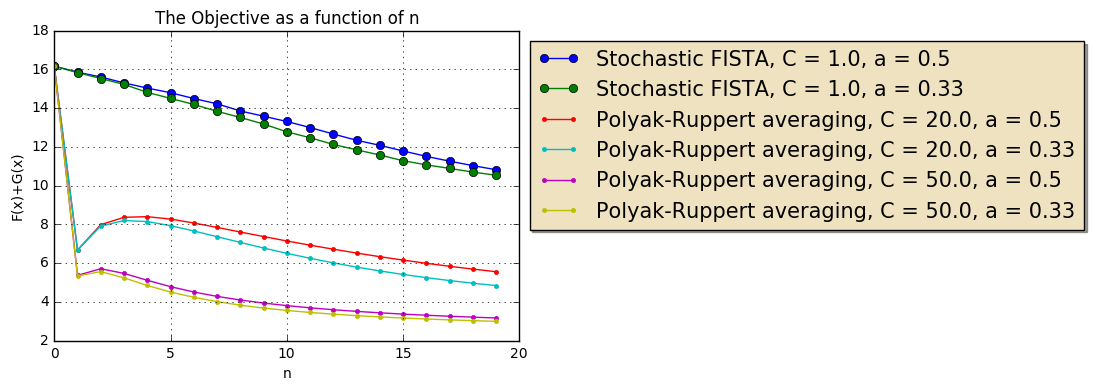

In [110]:
%matplotlib inline

for C_nest in C_nest_L:
    for alpha_nest in alpha_nest_L:
        plt.plot(Nesterov_mean[(C_nest, alpha_nest)],marker = 'o',label = 'Stochastic FISTA, C = '+str(C_nest)+ ', a = '+str(alpha_nest))
for C_pol in C_pol_L:
    for alpha_pol in alpha_pol_L:
        plt.plot(Polyak_mean[(C_pol, alpha_pol)],marker = '.',label = 'Polyak-Ruppert averaging, C = '+str(C_pol)+ ', a = '+str(alpha_pol))


plt.xlabel('n')
plt.ylabel('F(x)+G(x)')
plt.title('The Objective as a function of n')
legend = plt.legend(loc = 'upper left', shadow = True, fontsize = 'x-large', prop={'size': 15}, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('#efe2c1')
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.savefig('Nesterov-tv-'+str(size)+'.png')
plt.show()

#Simu pour le SGD sans averaging? Quel est le pas?
#mesurer la sparsité